In [1]:
#needs version >= 1.5 for full functionality
import tequila as tq

In [2]:
#Initialize molecule
import tequila as tq
geomstring="O 0.0 0.0 0.0\nO 0.0 0.0 1.207"
molecule = tq.chemistry.Molecule(geometry = geomstring, basis_set="cc-pVDZ")
print(molecule)

<class 'tequila.quantumchemistry.psi4_interface.QuantumChemistryPsi4'>
Qubit Encoding
JordanWigner

Parameters
basis_set       : cc-pVDZ         
geometry        : O 0.0 0.0 0.0
O 0.0 0.0 1.207 
description     :                 
multiplicity    : 1               
charge          : 0               
name            : o2              
frozen_core     : True            
n_qubits        : 52              
reference state : [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 

Basis

IntegralManager:
ActiveSpace:
Active Space Data:
active_orbitals : [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27] 
reference_orbitals : [0, 1, 2, 3, 4, 5, 6, 7] 
active_reference_orbitals : [2, 3, 4, 5, 6, 7] 
frozen_docc     : [1, 0, 0, 0, 0, 1, 0, 0] 
frozen_uocc     : [0, 0, 0, 0, 0, 0, 0, 0] 
Orbitals:
{irrep:AG, idx_irrep:0, idx_total:0, energy:-20.73659

In [3]:
#Excited state calculations of molecular oxygen with VQE
import tequila as tq
geomstring="O 0.0 0.0 0.0\nO 0.0 0.0 {R}"
fci_gs = []
fci_es = []
energies_gs = []
energies_es = []
P0 = tq.paulis.Projector("|00>")
for R in [0.3 + 0.1*i for i in range(25)]:
    print("Optimizing point R={:2.1f}".format(R))
    active = {"AG":[2,3,4], "B1G":[0]}
    mol = tq.chemistry.Molecule(geometry=geomstring.format(R=R), basis_set="cc-pVDZ", active_orbitals=active)
    H = mol.make_hamiltonian()
    results = []
    for i in range(2):
        # labeling ensures that tequila can distinguish the variables
        # singles can break the symmetry here falling into different states than the two above
        # (i.e. the open-shell singly excited manifold: in jordan_wigner those states are build from
        #  |1001> and |0110>)
        U = mol.make_upccgsd_ansatz(name="2-UpCCGD", label=i) 
        E = tq.ExpectationValue(U, H)
        active_vars = E.extract_variables()
        angles = {angle: 0.0 for angle in active_vars}
        for data, U2 in results:
            S2 = tq.ExpectationValue(H=P0, U=U + U2.dagger())
            E -= data.energy * S2
            angles = {**angles, **data.angles}
        print("Starting to optimize state ", i)
        result = tq.optimizer_scipy.minimize(E, silent=True, method="bfgs", variables=active_vars, initial_values=angles)
        print("finished with energy {:2.8f}".format(result.energy))
        results.append((result, U))
    energies_gs.append(results[0][0].energy)
    energies_es.append(results[1][0].energy)

Optimizing point R=0.3
Starting to optimize state  0
finished with energy -120.97901886
Starting to optimize state  1
finished with energy -119.60141754
Optimizing point R=0.4
Starting to optimize state  0
finished with energy -135.45218385
Starting to optimize state  1
finished with energy -132.37187195
Optimizing point R=0.5
Starting to optimize state  0
finished with energy -142.59877419
Starting to optimize state  1
finished with energy -139.38215637
Optimizing point R=0.6
Starting to optimize state  0
finished with energy -146.13617264
Starting to optimize state  1
finished with energy -143.09034729
Optimizing point R=0.7
Starting to optimize state  0
finished with energy -147.92350206
Starting to optimize state  1
finished with energy -144.99252319
Optimizing point R=0.8
Starting to optimize state  0
finished with energy -148.82869738
Starting to optimize state  1
finished with energy -145.93872070
Optimizing point R=0.9
Starting to optimize state  0
finished with energy -149.272

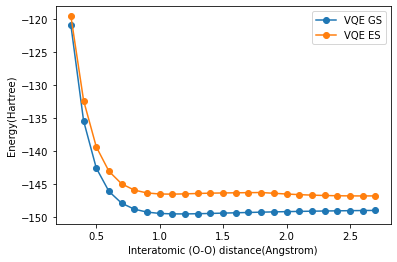

In [4]:
import matplotlib.pyplot as plt
R =  [0.3 + 0.1*i for i in range(len(energies_gs))]
plt.figure()
plt.plot(R, energies_gs, marker="o", label="VQE GS")
plt.plot(R, energies_es, marker="o", label="VQE ES")
plt.xlabel('Interatomic (O-O) distance(Angstrom)')
plt.ylabel('Energy(Hartree)')
plt.legend()
plt.show()